## 4.4 評価


In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# 乱数の種
random_seed = 123

### 4.4.1 混同行列

#### 混同行列

In [3]:
# データ読み込みからデータ分割まで

# ライブラリのimport
from sklearn.datasets import load_breast_cancer

# データのロード
cancer = load_breast_cancer()

# 入力データ x
x = cancer.data

# 正解データ y
# 良性: 0 悪性: 1に値を変更する
y = 1- cancer.target

# 入力データを2次元に絞り込み (「2列に絞り込み」の誤記？(kj))
x2 = x[:,:2]

# (4) データ分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x2, y, 
    train_size=0.7, test_size=0.3, random_state=random_seed)

In [4]:
print(x)

[[ 17.99    10.38   122.8    ...   0.2654   0.4601   0.1189]
 [ 20.57    17.77   132.9    ...   0.186    0.275    0.089 ]
 [ 19.69    21.25   130.     ...   0.243    0.3613   0.0876]
 ...
 [ 16.6     28.08   108.3    ...   0.1418   0.2218   0.0782]
 [ 20.6     29.33   140.1    ...   0.265    0.4087   0.124 ]
 [  7.76    24.54    47.92   ...   0.       0.2871   0.0704]]


In [5]:
# アルゴリズム選定から評価まで

# アルゴリズム選定 (ロジスティック回帰)
from sklearn.linear_model import LogisticRegression
algorithm = LogisticRegression(random_state=random_seed)

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

# 評価
score = algorithm.score(x_test, y_test)

# 結果確認
print(f'score: {score:.4f}')

score: 0.8772


In [6]:
# 混同行列の計算

# 必要ライブラリの取込み
from sklearn.metrics import confusion_matrix

# 混同行列の生成
#   y_test: 検証データの正解データ
#   y_pred: 検証データの予測結果
matrix = confusion_matrix(y_test, y_pred)

# 結果確認
print(matrix)

[[101   2]
 [ 19  49]]


In [7]:
type(matrix)

numpy.ndarray

In [8]:
# 混同行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列
    
    # columns 項目名リスト
    n = len(columns)
    
    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n
    
    # 以下はマルチインデックスを使って行ラベル、列ラベルを階層的に持たせている
    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

In [9]:
# make_cmを使った混同行列標示
cm = make_cm(matrix, ['良性', '悪性'])
display(cm)

予測結果    
           良性  悪性
正解データ 良性  101   2
      悪性   19  49

### 4.4.2 精度・適合率・再現率・F値

In [10]:
# 適合率・再現率・F値の計算

# ライブラリの取込み
from sklearn.metrics import precision_recall_fscore_support

# 適合率・再現率・F値の計算
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary')

# 結果の確認
print(f'適合率: {precision:.4f}')
print(f'再現率: {recall:.4f}')
print(f'F値:   {fscore:.4f}')

適合率: 0.9608
再現率: 0.7206
F値:   0.8235


### 4.4.3 確率値と閾値

In [11]:
# 確率値の取得
y_proba = algorithm.predict_proba(x_test)
print(y_proba[10:20,:])

[[0.7889 0.2111]
 [0.0812 0.9188]
 [0.8383 0.1617]
 [0.9391 0.0609]
 [0.369  0.631 ]
 [0.9451 0.0549]
 [0.9399 0.0601]
 [0.9494 0.0506]
 [0.9617 0.0383]
 [0.9836 0.0164]]


In [12]:
# positive(1)の確率値の取得
y_proba1 = y_proba[:,1]

# 結果確認
print(y_pred[10:20])
print(y_proba1[10:20])

[0 1 0 0 1 0 0 0 0 0]
[0.2111 0.9188 0.1617 0.0609 0.631  0.0549 0.0601 0.0506 0.0383 0.0164]


In [13]:
# 閾値を変化させる
thres = 0.5
print((y_proba1[10:20] > thres).astype(int))

thres = 0.7
print((y_proba1[10:20] > thres).astype(int))

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


In [14]:
# 閾値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
    # 確率値の取得(行列)
    y_proba = algorithm.predict_proba(x)
    
    # 予測結果1の確率値
    y_proba1 =  y_proba[:,1]
    
    # 予測結果1の確率値 > 閾値
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [15]:
# 閾値0.5で予測結果取得
pred_05 = pred(algorithm, x_test, 0.5)

# 閾値0.7で予測結果取得
pred_07 = pred(algorithm, x_test, 0.7)

# 結果確認
print(pred_05[10:20])
print(pred_07[10:20])

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


### 4.4.4 PR曲線とROC曲線

#### PR曲線

In [16]:
# PR曲線用配列の生成

# ライブラリの導入
from sklearn.metrics import precision_recall_curve
# 適合率, 再現率、閾値の取得
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba1)
# 結果をデータフレームにする
df_pr = pd.DataFrame([thresholds, precision, recall]).T
df_pr.columns = ['閾値', '適合率', '再現率']
# 閾値 0.5の周辺を表示
display(df_pr[52:122:10])

,閾値,適合率,再現率
52,0.0322,0.5462,0.9559
62,0.0491,0.5963,0.9559
72,0.0601,0.6465,0.9412
82,0.0987,0.7191,0.9412
92,0.1602,0.8101,0.9412
102,0.2170,0.8551,0.8676
112,0.3624,0.9492,0.8235


In [17]:

print(thresholds)

[0.0001 0.0003 0.0005 0.0007 0.0008 0.0011 0.0012 0.0016 0.0019 0.0027
 0.0033 0.0036 0.004  0.004  0.004  0.0041 0.0046 0.0063 0.0072 0.0075
 0.009  0.0094 0.0102 0.013  0.0134 0.0134 0.0139 0.0142 0.0152 0.0157
 0.0164 0.0167 0.0172 0.0191 0.021  0.022  0.0222 0.0223 0.0224 0.0225
 0.0229 0.023  0.0231 0.0236 0.0254 0.0257 0.0278 0.0285 0.0297 0.0306
 0.0308 0.0318 0.0322 0.0329 0.0337 0.0374 0.0379 0.0383 0.0402 0.0419
 0.0464 0.0475 0.0491 0.0506 0.0526 0.0529 0.0538 0.0549 0.057  0.0572
 0.0579 0.0598 0.0601 0.0609 0.0622 0.0635 0.0783 0.079  0.0856 0.087
 0.087  0.0905 0.0987 0.1004 0.1031 0.1071 0.1094 0.1322 0.1343 0.1428
 0.1473 0.1578 0.1602 0.1617 0.1633 0.1663 0.1683 0.1803 0.1866 0.188
 0.2027 0.2111 0.217  0.2244 0.2356 0.24   0.2539 0.2765 0.2981 0.3121
 0.3371 0.3509 0.3624 0.3785 0.3825 0.3958 0.4242 0.4622 0.4912 0.4981
 0.5347 0.6089 0.612  0.631  0.653  0.6585 0.69   0.707  0.7149 0.7538
 0.7763 0.8209 0.8253 0.8345 0.8346 0.8574 0.8603 0.8664 0.8812 0.8897
 0.9025 

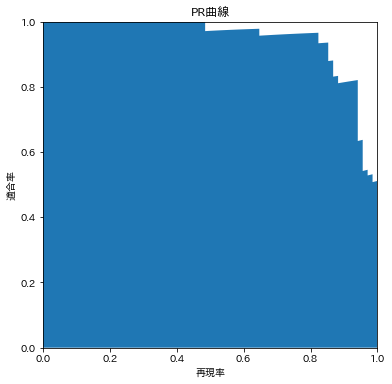

In [18]:
# PR曲線の描画

# 描画サイズ指定
plt.figure(figsize=(6,6))
# グラフ領域の塗りつぶし
plt.fill_between(recall, precision, 0)
# x, yの範囲指定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# ラベル・タイトル表示
plt.xlabel('再現率')
plt.ylabel('適合率')
plt.title('PR曲線')
plt.show()

In [19]:
# PR曲線下面積の計算
from sklearn.metrics import auc
pr_auc = auc(recall, precision)
print(f'PR曲線下面積: {pr_auc:.4f}')

PR曲線下面積: 0.9459


#### ROC曲線

In [20]:
# ROC曲線用配列の生成

# ライブラリの導入
from sklearn.metrics import roc_curve

# 偽陽性率, 敏感度と閾値の取得
fpr, tpr, thresholds = roc_curve(
    y_test, y_proba1,drop_intermediate=False)

# 結果をデータフレームにする
df_roc = pd.DataFrame([thresholds, fpr, tpr]).T
df_roc.columns = ['閾値', '偽陽性率', '敏感度']

# 閾値 0.5の周辺を表示
display(df_roc[21:91:10])

,閾値,偽陽性率,敏感度
21,0.9829,0.0000,0.3088
31,0.9025,0.0000,0.4559
41,0.7763,0.0097,0.5882
51,0.5347,0.0194,0.7206
61,0.3371,0.0388,0.8382
71,0.2027,0.1165,0.8676
81,0.1473,0.1650,0.9412


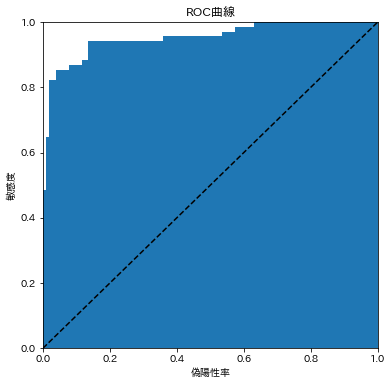

In [21]:
# ROC曲線の描画

# 描画サイズ指定
plt.figure(figsize=(6,6))

# 点線表示
plt.plot([0, 1], [0, 1], 'k--')

# グラフ領域の塗りつぶし
plt.fill_between(fpr, tpr, 0)

# x, yの範囲指定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# ラベル・タイトル表示
plt.xlabel('偽陽性率')
plt.ylabel('敏感度')
plt.title('ROC曲線')
plt.show()

In [22]:
# ROC曲線下面積の計算
roc_auc = auc(fpr, tpr)
print(f'ROC曲線下面積:{roc_auc:.4f}')

ROC曲線下面積:0.9522


#### より精度のいいモデルでROCカーブを描画

In [23]:
# "より精度がいい"というのは入力変数の数をオリジナルの30個にしたもの
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size=0.7, test_size=0.3, random_state=random_seed)
algorithm = LogisticRegression()
algorithm.fit(x_train, y_train)
y_pred = algorithm.predict(x_test)
y_proba1 = algorithm.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba1)

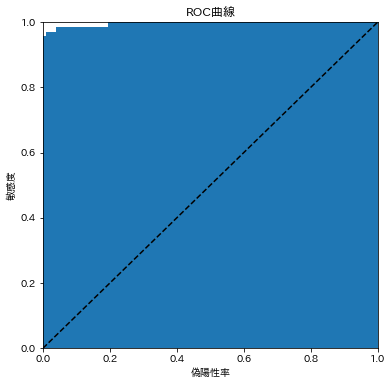

In [24]:
# ROC曲線の描画

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.fill_between(fpr, tpr, 0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('偽陽性率')
plt.ylabel('敏感度')
plt.title('ROC曲線')
plt.show()

In [25]:
# ROC AUCの計算
roc_auc = auc(fpr, tpr)
print(f'ROC曲線下面積:{roc_auc:.4f}')

ROC曲線下面積:0.9964


### 4.4.5 入力項目の重要度

#### ランダムフォレストのモデルを作るまで

In [26]:
# ランダムフォレストのモデルを作るまで

# サンプルデータの読み込み
import seaborn as sns
df_iris = sns.load_dataset("iris")
columns_i = ['がく片長', 'がく片幅', '花弁長', '花弁幅', '種別']
df_iris.columns = columns_i

# 入力データ x
x = df_iris[['がく片長', 'がく片幅', '花弁長', '花弁幅']]

# 正解データ y
y = df_iris['種別']

# アルゴリズムの選定(ランダムフォレスト)
from sklearn.ensemble import RandomForestClassifier
algorithm = RandomForestClassifier(random_state=random_seed)

# 学習
algorithm.fit(x, y)

RandomForestClassifier(random_state=123)

#### 重要度ベクトルの取得

In [27]:
# 重要度ベクトルの取得
importances = algorithm.feature_importances_

# 項目名をキーにSeriesを生成
w = pd.Series(importances, index=x.columns)

# 値の大きい順にソート
u = w.sort_values(ascending=False)

# 結果確認
print(u)

花弁長    0.4611
花弁幅    0.4257
がく片長   0.0874
がく片幅   0.0257
dtype: float64


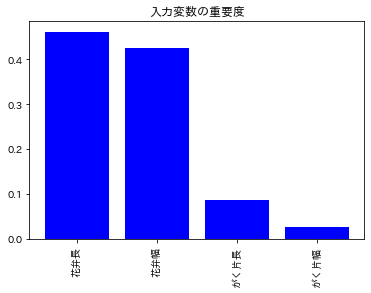

In [25]:
# 重要度の棒グラフ表示

# 棒グラフ表示
plt.bar(range(len(u)), u, color='b', align='center')

# 項目名表示(90度回転)
plt.xticks(range(len(u)), u.index, rotation=90)

# タイトル表示
plt.title('入力変数の重要度')

plt.show()

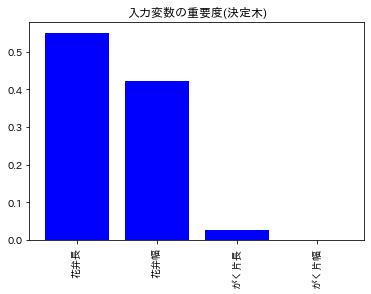

In [26]:
# 決定木の場合

from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(random_state=random_seed)
algorithm.fit(x, y)
importances = algorithm.feature_importances_
w = pd.Series(importances, index=x.columns)
u = w.sort_values(ascending=False)
plt.title('入力変数の重要度(決定木)')
plt.bar(range(len(u)), u, color='b', align='center')
plt.xticks(range(len(u)), u.index, rotation=90)
plt.show()

In [28]:
y

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: 種別, Length: 150, dtype: object

In [30]:
# XGBoostの場合

import xgboost
algorithm = xgboost.XGBClassifier(random_state=random_seed)
algorithm.fit(x, y)
importances = algorithm.feature_importances_
w = pd.Series(importances, index=x.columns)
u = w.sort_values(ascending=False)
plt.title('入力変数の重要度(XGBoost)')
plt.bar(range(len(u)), u, color='b', align='center')
plt.xticks(range(len(u)), u.index, rotation=90)
plt.show()

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['setosa' 'versicolor' 'virginica']

### 4.4.6 回帰モデルの評価方法

In [32]:
# データ読み込みからデータ分割まで

# データ読み込み(ボストン・データセット)
# 2023/02/10 load_boston はエラーがでるようになっている。scikit-learn に変更があったようだ 
from sklearn.datasets import load_boston
boston = load_boston()

# df: 入力データ
df = pd.DataFrame(boston.data, columns=boston.feature_names)

# y: 正解データ
y = boston.target

# 1項目だけの入力データ df1を作る
df1 = df[['RM']]

# 結果確認
display(df.head())
display(df1.head())
print(y[:5])

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [32]:
# アルゴリズム選定から予測まで

# アルゴリズム: XGBRegressor
from xgboost import XGBRegressor
algorithm1 = XGBRegressor(objective ='reg:squarederror',
    random_state=random_seed)

# 学習 (入力データにdf1を利用)
algorithm1.fit(df1, y)

# 予測
y_pred1 = algorithm1.predict(df1)


# アルゴリズム: XGBRegressor
from xgboost import XGBRegressor
algorithm2 = XGBRegressor(objective ='reg:squarederror',
    random_state=random_seed)

# 学習 (入力データにdfを利用)
algorithm2.fit(df, y)

# 予測
y_pred2 = algorithm2.predict(df)

NameError: name 'df1' is not defined

In [33]:
# 結果確認
print(f'y[:5] {y[:5]}')
print(f'y_pred1[:5] {y_pred1[:5]}')
print(f'y_pred2[:5] {y_pred2[:5]}')

y[:5] 0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: 種別, dtype: object


NameError: name 'y_pred1' is not defined

In [31]:
# yの最大値と最小値の計算
y_range = np.array([y.min(), y.max()])

# 結果確認
print(y_range)

[ 5. 50.]


#### 散布図表示

#### 1入力変数の場合

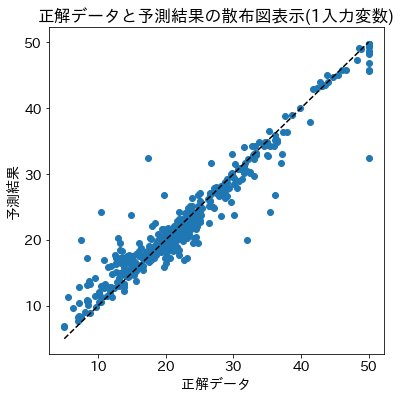

In [32]:
# 散布図による結果確認(1入力変数)

# 描画サイズ指定
plt.figure(figsize=(6,6))

# 散布図
plt.scatter(y, y_pred1)

# 正解データ=予測結果の直線
plt.plot(y_range, y_range, 'k--')

# ラベル・タイトル
plt.xlabel('正解データ')
plt.ylabel('予測結果')
plt.title('正解データと予測結果の散布図表示(1入力変数)')

plt.show()

#### 13入力変数の場合

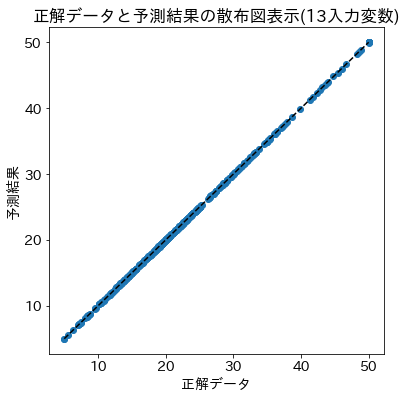

In [33]:
# 散布図による結果確認(13入力変数)

# 描画サイズ指定
plt.figure(figsize=(6,6))

# 散布図
plt.scatter(y, y_pred2)

# 正解データ=予測結果の直線
plt.plot(y_range, y_range, 'k--')

# ラベル・タイトル
plt.xlabel('正解データ')
plt.ylabel('予測結果')
plt.title('正解データと予測結果の散布図表示(13入力変数)')

plt.show()

#### R2 score

In [34]:
# r2 scoreの計算(1入力変数)
from sklearn.metrics import r2_score
r2_score1 = r2_score(y, y_pred1)
print(f'R2 score(1入力変数): {r2_score1:.4f}')

R2 score(1入力変数): 0.9251


In [35]:
# r2 scoreの計算(13入力変数)
r2_score2 = r2_score(y, y_pred2)
print(f'R2 score(13入力変数): {r2_score2:.4f}')

R2 score(13入力変数): 1.0000
